<a href="https://colab.research.google.com/github/Richard-CYao/Prediction-for-ventilator/blob/main/Prediction_for_ventilator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I download these data from kaggle and collected them in a folder named pressure_ data. 
Before analysing, we need to know the following column information in detail:

- id - globally-unique time step identifier across an entire file
- breath_id - globally-unique time step for breaths
- R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
- C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
- time_step - the actual time stamp.
- u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
- u_out - the control input for the exploratory solenoid valve. Either 0 or 1.
- pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.

if you want, you can know more detail and download data from this URL:
https://www.kaggle.com/competitions/ventilator-pressure-prediction/overview

###Getting An Overview of the Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

sub = pd.read_csv("/content/drive/MyDrive/pressure_data/sample_submission.csv")
df_test = pd.read_csv("/content/drive/MyDrive/pressure_data/test.csv")
df_train = pd.read_csv("/content/drive/MyDrive/pressure_data/train.csv")

In [ ]:
# Intercept some training data to observe
df = df_train[df_train['breath_id'] < 5].reset_index(drop=True)
df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


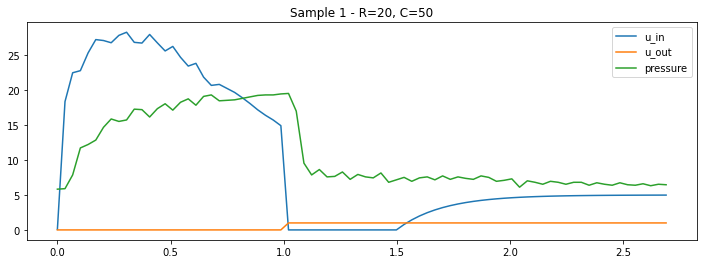

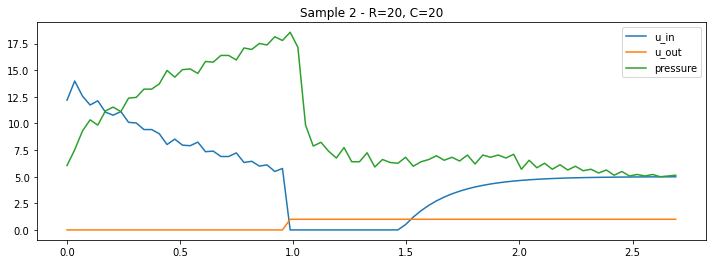

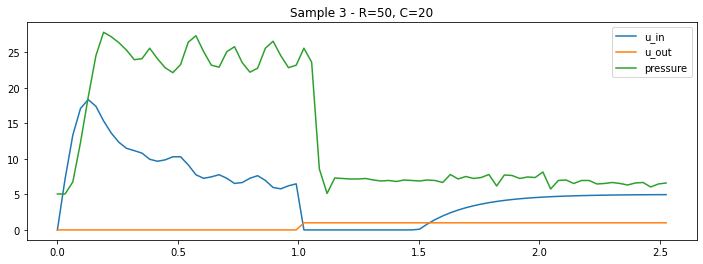

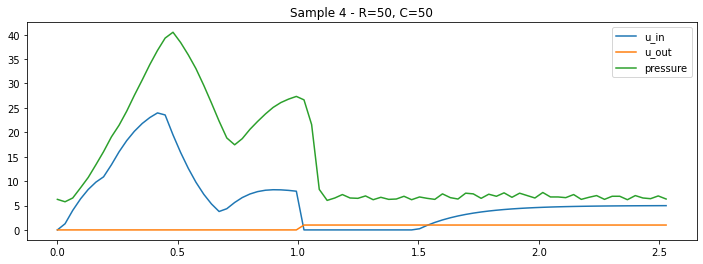

In [ ]:
# Visualize a breathing process
def plot_sample(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]
    r, c  = df_breath[['R', 'C']].values[0]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    plt.figure(figsize=(12, 4))
    for col in ['u_in', 'u_out', 'pressure']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    plt.legend()
    plt.title(f'Sample {sample_id} - R={r}, C={c}')
    
for i in df['breath_id'].unique():
    plot_sample(i, df_train)

In [ ]:
df_train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01



###Data preprocessing

- Discrete data needs to be coded. OneHot coding is used here
- Check whether there are null values. If yes, null values need to be processed

In [ ]:

df_train['last_value_u_in'] = df_train.groupby('breath_id')['u_in'].transform('last')
df_train['u_in_lag1'] = df_train.groupby('breath_id')['u_in'].shift(1)
df_train['u_out_lag1'] = df_train.groupby('breath_id')['u_out'].shift(1)
df_train['u_in_lag_back1'] = df_train.groupby('breath_id')['u_in'].shift(-1)
df_train['u_out_lag_back1'] = df_train.groupby('breath_id')['u_out'].shift(-1)
df_train['u_in_lag2'] = df_train.groupby('breath_id')['u_in'].shift(2)
df_train['u_out_lag2'] = df_train.groupby('breath_id')['u_out'].shift(2)
df_train['u_in_lag_back2'] = df_train.groupby('breath_id')['u_in'].shift(-2)
df_train['u_out_lag_back2'] = df_train.groupby('breath_id')['u_out'].shift(-2)
df_train['u_in_lag3'] = df_train.groupby('breath_id')['u_in'].shift(3)
df_train['u_out_lag3'] = df_train.groupby('breath_id')['u_out'].shift(3)
df_train['u_in_lag_back3'] = df_train.groupby('breath_id')['u_in'].shift(-3)
df_train['u_out_lag_back3'] = df_train.groupby('breath_id')['u_out'].shift(-3)
df_train = df_train.fillna(0)


df_train['R__C'] = df_train["R"].astype(str) + '__' + df_train["C"].astype(str)

# max value of u_in and u_out for each breath
df_train['breath_id__u_in__max'] = df_train.groupby(['breath_id'])['u_in'].transform('max')
df_train['breath_id__u_out__max'] = df_train.groupby(['breath_id'])['u_out'].transform('max')

# difference between consequitive values
df_train['u_in_diff1'] = df_train['u_in'] - df_train['u_in_lag1']
df_train['u_out_diff1'] = df_train['u_out'] - df_train['u_out_lag1']
df_train['u_in_diff2'] = df_train['u_in'] - df_train['u_in_lag2']
df_train['u_out_diff2'] = df_train['u_out'] - df_train['u_out_lag2']

# difference between the current value of u_in and the max value within the breath
df_train['breath_id__u_in__diffmax'] = df_train.groupby(['breath_id'])['u_in'].transform('max') - df_train['u_in']
df_train['breath_id__u_in__diffmean'] = df_train.groupby(['breath_id'])['u_in'].transform('mean') - df_train['u_in']

# OHE-HOT 
df_train = df_train.merge(pd.get_dummies(df_train['R'], prefix='R'), left_index=True, right_index=True).drop(['R'], axis=1)
df_train = df_train.merge(pd.get_dummies(df_train['C'], prefix='C'), left_index=True, right_index=True).drop(['C'], axis=1)
df_train = df_train.merge(pd.get_dummies(df_train['R__C'], prefix='R__C'), left_index=True, right_index=True).drop(['R__C'], axis=1)


df_train['u_in_cumsum'] = df_train.groupby(['breath_id'])['u_in'].cumsum()
df_train['time_step_cumsum'] = df_train.groupby(['breath_id'])['time_step'].cumsum()

In [ ]:
# Check whether there is a null value
df_train.isnull().sum()

id                           0
breath_id                    0
time_step                    0
u_in                         0
u_out                        0
pressure                     0
last_value_u_in              0
u_in_lag1                    0
u_out_lag1                   0
u_in_lag_back1               0
u_out_lag_back1              0
u_in_lag2                    0
u_out_lag2                   0
u_in_lag_back2               0
u_out_lag_back2              0
u_in_lag3                    0
u_out_lag3                   0
u_in_lag_back3               0
u_out_lag_back3              0
breath_id__u_in__max         0
breath_id__u_out__max        0
u_in_diff1                   0
u_out_diff1                  0
u_in_diff2                   0
u_out_diff2                  0
breath_id__u_in__diffmax     0
breath_id__u_in__diffmean    0
R_5                          0
R_20                         0
R_50                         0
C_10                         0
C_20                         0
C_50    

###Regression analysis and prediction

In [ ]:
from sklearn.model_selection import train_test_split
columns = [col for col in df_train.columns if col not in ['id', 'breath_id', 'pressure']]
X_train = df_train[columns].values[::10]
y_train = df_train['pressure'].values[::10]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
X_train.shape

(482880, 41)

**Baseline：KNN**

In [ ]:
import time
from sklearn.neighbors import KNeighborsRegressor

start_time = time.time()
model = KNeighborsRegressor()
model.fit(X_train, y_train)
# R2 score
print("train score {}, test score {}".format(model.score(X_train, y_train),model.score(X_test, y_test)))
print("--- %s seconds ---" % (time.time() - start_time))

train score 0.9508627064039821, test score 0.9226859016912385
--- 7019.4247834682465 seconds ---


In [ ]:
# MAE score
from sklearn import metrics
train_score = metrics.mean_absolute_error(y_train, model.predict(X_train))
test_score = metrics.mean_absolute_error(y_test, model.predict(X_test))

print("train score {}, test score {}".format(train_score, test_score))

train score 0.13244028322055937, test score 0.3544167067569962


**Random forest**

In [ ]:
import time
from sklearn.ensemble import RandomForestRegressor

start_time = time.time()
model = RandomForestRegressor()
model.fit(X_train, y_train)
# R2 score
print("train score {}, test score {}".format(model.score(X_train, y_train),model.score(X_test, y_test)))
print("--- %s seconds ---" % (time.time() - start_time))

train score 0.9990478457111018, test score 0.9932229967351466
--- 1839.365404367447 seconds ---


In [ ]:
# MAE score
from sklearn import metrics
train_score = metrics.mean_absolute_error(y_train, model.predict(X_train))
test_score = metrics.mean_absolute_error(y_test, model.predict(X_test))

print("train score {}, test score {}".format(train_score, test_score))

train score 0.13244028322055937, test score 0.3544167067569962
